# 5.5 공식문서에 없는 MCP Client 활용방법

- 3.8 커스텀 도구(tool)를 최대한 활용하는 방법에서 생성한 에이전트가 활용하는 도구를 [MCP 서버](https://github.com/modelcontextprotocol/servers)로 이전



In [1]:
from dotenv import load_dotenv

load_dotenv()

True

- 도구(tool)을 활용하려면 [`AIMessage`](https://python.langchain.com/api_reference/core/messages/langchain_core.messages.ai.AIMessage.html)를 활용해야하기 때문에 상태에 `messages`가 필요함
- 직접 선언하지 않고 랭그래프에서 제공하는 `MessagesState`를 사용

In [2]:

from langgraph.graph import StateGraph, MessagesState

class AgentState(MessagesState):
    pass

graph_builder = StateGraph(AgentState)

In [3]:
query = '5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?'

In [4]:
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    azure_deployment='gpt-4o-2024-11-20',
    api_version='2024-08-01-preview',   
    temperature=0
)

- MCP 서버와 연결하기 위한 MCP 클라이언트 생성
    - LangChain에서 제공하는 [langchain-mcp-adapters](https://github.com/langchain-ai/langchain-mcp-adapters)활용
    - `MultiServerMCPClient`를 활용하면 복수의 MCP 서버와 연결할 수 있음

In [5]:
# MCP 클라이언트를 생성하기 위한 MultiServerMCPClient 클래스를 임포트합니다
from langchain_mcp_adapters.client import MultiServerMCPClient

# 여러 MCP 서버에 연결할 수 있는 클라이언트 인스턴스를 생성합니다
mcp_client = MultiServerMCPClient()

# 표준 입출력을 통해 MCP 서버에 연결합니다
# - server_name: 연결할 서버의 이름 (house_tax_tools)
# - url: 서버의 주소 (http://127.0.0.1:8000/sse)
await mcp_client.connect_to_server_via_sse(server_name='house_tax_tools', url="http://127.0.0.1:8000/sse")

Error in sse_reader: peer closed connection without sending complete message body (incomplete chunked read)


In [6]:
from langgraph.prebuilt import ToolNode

tool_list = mcp_client.get_tools() # 기존에 로컬에 선언했던 도구들을 mcp 서버로 이전함
llm_with_tools = llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

In [7]:
tool_list

[StructuredTool(name='tax_deductible_tool', description="사용자의 부동산 소유 현황에 대한 질문을 기반으로 세금 공제액을 계산합니다.\n    \n    이 도구는 다음 두 단계로 작동합니다:\n    1. tax_deductible_chain을 사용하여 일반적인 세금 공제 규칙을 검색\n    2. user_deductible_chain을 사용하여 사용자의 특정 상황에 규칙을 적용\n\n    Args:\n        question (str): 부동산 소유에 대한 사용자의 질문\n        \n    Returns:\n        str: 세금 공제액 (예: '9억원', '12억원')\n    ", args_schema={'properties': {'question': {'title': 'Question', 'type': 'string'}}, 'required': ['question'], 'title': 'tax_deductible_toolArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x10fb80e00>),
 StructuredTool(name='tax_base_tool', description='종합부동산세 과세표준을 계산하기 위한 공식을 검색하고 형식화합니다.\n    \n    이 도구는 RAG(Retrieval Augmented Generation) 방식을 사용하여:\n    1. 지식 베이스에서 과세표준 계산 규칙을 검색\n    2. 검색한 규칙을 수학 공식으로 형식화\n\n    Returns:\n        str: 과세표준 계산 공식\n    ', args_schema={'properties': {}, 'title': 'tax_base_toolArguments', 'ty

In [8]:
from langchain_core.messages import SystemMessage


async def agent(state: MessagesState) -> MessagesState:
    """
    에이전트 함수는 주어진 상태에서 메시지를 가져와
    LLM과 도구를 사용하여 응답 메시지를 생성합니다.

    Args:
        state (MessagesState): 메시지 상태를 포함하는 state.

    Returns:
        MessagesState: 응답 메시지를 포함하는 새로운 state.
    """
    # 서버에서 시스템 프롬프트를 가져옴
    # MCP의 `mcp.prompt()`는 list of prompts를 반환함
    system_message = await mcp_client.get_prompt(server_name='house_tax_tools', prompt_name='house_tax_system_prompt', arguments={})
    messages = system_message + state['messages']
    response = llm_with_tools.invoke(messages)
    return {'messages': [response]}

- `node` 를 선언하고 `edge` 로 연결함

In [9]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)

In [10]:
from langgraph.graph import START, END
from langgraph.prebuilt import tools_condition


graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    tools_condition
)
graph_builder.add_edge('tools', 'agent')

In [11]:
graph = graph_builder.compile()

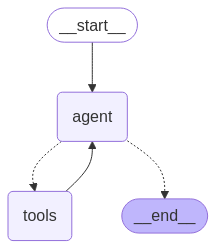

In [12]:
graph

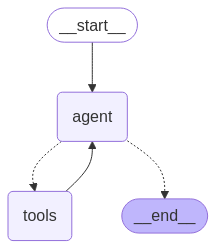

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

- MCP 서버와 MCP 클라이언트 사용시 [`astream()`](https://python.langchain.com/api_reference/core/runnables/langchain_core.runnables.base.Runnable.html#langchain_core.runnables.base.Runnable.astream)을 활용해야하기 때문에 generator의 내용을 print할 수 있는 함수 생성

In [14]:
async def process_stream(stream_generator):
    results = []
    try:
        async for chunk in stream_generator:

            key = list(chunk.keys())[0]
            
            if key == 'agent':
                # Agent 메시지의 내용을 가져옴. 메세지가 비어있는 경우 어떤 도구를 어떻게 호출할지 정보를 가져옴
                content = chunk['agent']['messages'][0].content if chunk['agent']['messages'][0].content != '' else chunk['agent']['messages'][0].additional_kwargs
                print(f"'agent': '{content}'")
            
            elif key == 'tools':
                # 도구 메시지의 내용을 가져옴
                for tool_msg in chunk['tools']['messages']:
                    print(f"'tools': '{tool_msg.content}'")
            
            results.append(chunk)
        return results
    except Exception as e:
        print(f"Error processing stream: {e}")
        return results

In [15]:
from langchain_core.messages import HumanMessage

stream_generator = graph.astream({'messages': [HumanMessage(content=query)]})


all_chunks = await process_stream(stream_generator)


if all_chunks:
    final_result = all_chunks[-1]
    print("\nFinal result:", final_result)

'agent': '{'tool_calls': [{'id': 'call_kD0hvNmrukbtsyUFgPy3uzKX', 'function': {'arguments': '{}', 'name': 'tax_base_tool'}, 'type': 'function'}, {'id': 'call_Hi3vOcwSxq9Zfjvp3Xrvt3ZZ', 'function': {'arguments': '{"question": "5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 공제액은 얼마인가요?"}', 'name': 'tax_deductible_tool'}, 'type': 'function'}, {'id': 'call_kOWpE2t9uFnFKdw0a1NCLT6x', 'function': {'arguments': '{"question": "5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 공정시장가액비율은 얼마인가요?"}', 'name': 'market_value_rate_tool'}, 'type': 'function'}], 'refusal': None}'
'tools': '9억원'
'tools': '공제액은 9억 원입니다.'
'tools': '60%'
'agent': '{'tool_calls': [{'id': 'call_B3GOo45i6UZ3nR0kjCvB5R6O', 'function': {'arguments': '{"tax_base_question":"9억원","market_value_rate":"60%","tax_deductible":"9억원","question":"5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?"}', 'name': 'house_tax_tool'}, 'type': 'function'}], 'refusal': None}'
'tools': '주어진 조건에 따라 종합부동산세를 계산해 보겠습니다. 

### 1. 주어진 정보
- 집 1: 5억 원
- 집 2: 1